In [139]:
using DataFrames #for data wrangling
using StatsPlots #for plotting
using Turing #for MCMC
using CSV #CSV import
using Random #data generation (if required)
using Distributions
using LogExpFunctions #for logistic function

Import Data

In [140]:
#this is a local document, but i've also saved a slightly cleaned up version in github with the same "valveTestRaw" title
valveData = CSV.read("./Results of New Valve Tests.csv", DataFrame)

Row,Vendor,Population,Rejected,High Pop,% Over Set,% Over Limit,Set Pressure,Service
,String1,Int64,Int64,Int64,String7,String7,Int64?,String15
1,a,9,2,1,10.00%,4.30%,35,steam
2,b,13,0,0,0.00%,0.00%,missing,air
3,c,85,1,1,13.00%,9.70%,175,steam
4,d,108,21,4,4.50%,1.50%,350,air
5,e,1,0,0,0.00%,0.00%,missing,na
6,f,55,9,2,5.50%,2.50%,400,liquid
7,g,41,5,2,6.70%,3.30%,165,steam
8,h,2,0,0,0.00%,0.00%,missing,air
9,z,40,6,1,24.00%,20.00%,165,steam


Collect Number of Trials & Separate into Service Mediums

In [141]:
# vendors = (collect(valveData[:,1]))
# n=0
# for i in 1:length(vendors)
#     n = valveData[i, 2] + n
# end
# n

steamDF = []
airDF = []
liquidDF = []
airLiqDF = []

steamDF = filter(:Service => ==("steam"), valveData)
airDF = filter(:Service => ==("air"), valveData)
liquidDF = filter(:Service => ==("liquid"), valveData)
airLiqDF = filter(:Service => ==("air/liquid"), valveData)
naDF = filter(:Service => ==("na"), valveData)

n_steam = 0
n_air = 0
n_liquid = 0
n_airLiq = 0
n_na = 0

steamVend = (collect(steamDF[:,1]))
for i in 1:length(steamVend)
    n_steam = steamDF[i,2] +n_steam
end

airVend = (collect(airDF[:,1]))
for i in 1:length(airVend)
    n_air = airDF[i,2] +n_air
end

liquidVend = (collect(liquidDF[:,1]))
for i in 1:length(liquidVend)
    n_liquid = liquidDF[i,2] +n_liquid
end

airLiqVend = (collect(airLiqDF[:,1]))
for i in 1:length(airLiqVend)
    n_airLiq = airLiqDF[i,2] +n_airLiq
end

naVend = (collect(naDF[:,1]))
for i in 1:length(naVend)
    n_na = naDF[i,2]+n_na
end

steamDF

Row,Vendor,Population,Rejected,High Pop,% Over Set,% Over Limit,Set Pressure,Service
,String1,Int64,Int64,Int64,String7,String7,Int64?,String15
1,a,9,2,1,10.00%,4.30%,35,steam
2,c,85,1,1,13.00%,9.70%,175,steam
3,g,41,5,2,6.70%,3.30%,165,steam
4,z,40,6,1,24.00%,20.00%,165,steam
5,k,1,0,0,0.00%,0.00%,missing,steam
6,m,14,7,3,10.00%,3.00%,80,steam


Set Up Model

In [142]:
@model function valveTesting(Vendors, Population, rejects) # highpops serviceMedium)
    #additional functionality can be added to this, especially when considering that the probability of failing (p-1) is the sum of the probability of failing on a low pop (less dangerous) & a high pop (more dangerous)      
    
    
    #hyper prior
        μ_bar ~ Normal(-2, 2) #best first guess is that most valves are unlikely to fail, possibly with large spread
        σ ~ Exponential(1)
    
        μ = Vector{Real}(undef, length(Vendors))

    for i in 1:length(Vendors)
        μ[i] ~ Normal(μ_bar, σ)
    end

    for i in 1:length(Vendors)
        
        #prior
        n = Population[i]
        p = logistic(μ[i]) 
        #distribution of valves failing given fail probability p and n trials
        rejects[i] ~ Binomial(n, p)
    end
end

valveTesting (generic function with 2 methods)

In [143]:
steam_model = valveTesting(steamDF[:,1], steamDF[:,2], steamDF[:,3])

steam_posterior = sample(steam_model, NUTS(), 1000)

Sampling   0%|█                                         |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\flemm\.julia\packages\Turing\oFGEb\src\mcmc\hmc.jl:213
Sampling   0%|█                                         |  ETA: 0:03:10
Sampling   1%|█                                         |  ETA: 0:01:35
Sampling   1%|█                                         |  ETA: 0:01:04
Sampling   2%|█                                         |  ETA: 0:00:48
Sampling   2%|█                                         |  ETA: 0:00:38
Sampling   3%|██                                        |  ETA: 0:00:32
Sampling   3%|██                                        |  ETA: 0:00:27
Sampling   4%|██                                        |  ETA: 0:00:24
Sampling   4%|██                                        |  ETA: 0:00:21
Sampling   5%|██                                        |  ETA: 0:00:19
Sampling   5%|███                                       |  ETA: 0:00:17
Sampling  

Chains MCMC chain (1000×20×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 2.46 seconds
Compute duration  = 2.46 seconds
parameters        = μ_bar, σ, μ[1], μ[2], μ[3], μ[4], μ[5], μ[6]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64     Float64    Float64   Float64    ⋯

       μ_bar   -1.9790    0.6783    0.0232    877.9732   689.4622    1.0021    ⋯
           σ    1.4326    0.5872    0.0262    424.1106   251.0485    1.0012    ⋯
        μ[1]   -1.5751    0.8026    0.0234   1187.7048   704.8310    0.9992    ⋯
        μ[2]   -3.8441    0.8127    0.0332    576.2108   490.0578    1.0015    ⋯
        μ[3]   -2.0607    0.46

In [144]:
postDF = DataFrame(steam_posterior)



Row,iteration,chain,μ_bar,σ,μ[1],μ[2],μ[3],μ[4],μ[5],μ[6],lp,n_steps,is_accept,acceptance_rate,log_density,hamiltonian_energy,hamiltonian_energy_error,max_hamiltonian_energy_error,tree_depth,numerical_error,step_size,nom_step_size
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,501,1,-1.91991,0.897791,-0.949432,-3.11832,-1.68222,-1.23366,-2.85458,-0.259905,-21.2316,15.0,1.0,0.801653,-21.2316,26.6719,-1.20006,-1.20006,3.0,0.0,0.629317,0.629317
2,502,1,-1.4108,1.32608,-1.67382,-4.49,-1.93074,-2.19494,-0.623032,-0.438336,-21.8642,7.0,1.0,0.777016,-21.8642,23.8355,0.28006,0.384868,3.0,0.0,0.629317,0.629317
3,503,1,-1.86341,1.40398,-1.94974,-3.08193,-1.80899,-1.19908,-0.971327,-0.255567,-21.8522,15.0,1.0,0.577428,-21.8522,24.4685,0.080553,1.47511,3.0,0.0,0.629317,0.629317
4,504,1,-1.22188,1.80761,-2.09934,-3.84254,-1.92489,-1.76873,-0.337486,0.178227,-22.1262,7.0,1.0,0.760609,-22.1262,24.1336,-0.130596,1.77552,3.0,0.0,0.629317,0.629317
5,505,1,-1.74639,1.37365,-2.76987,-3.22967,-2.07367,-1.57114,0.250377,0.0876072,-23.4467,7.0,1.0,0.868274,-23.4467,26.4088,0.0188554,0.500696,2.0,0.0,0.629317,0.629317
6,506,1,-2.06322,0.7634,-0.997953,-3.76537,-1.62696,-2.006,-2.64605,-1.69667,-23.1261,3.0,1.0,0.681393,-23.1261,28.5295,-1.01871,3.11951,2.0,0.0,0.629317,0.629317
7,507,1,-1.78856,1.09832,-1.51486,-3.482,-1.99843,-2.15362,-3.80953,-1.33589,-22.9482,3.0,1.0,0.379053,-22.9482,27.5125,0.637305,5.92815,2.0,0.0,0.629317,0.629317
8,508,1,-2.80205,1.16933,-2.39664,-4.28356,-2.83027,-1.798,-0.938959,0.154367,-24.5212,7.0,1.0,0.963614,-24.5212,25.8169,0.293973,-0.320998,3.0,0.0,0.629317,0.629317
9,509,1,-1.13355,1.60025,-3.35765,-3.80429,-2.66848,-2.10083,-0.66344,-0.956856,-27.0447,15.0,1.0,0.894891,-27.0447,29.8686,0.27772,-0.4197,3.0,0.0,0.629317,0.629317


Vendor 1 Check

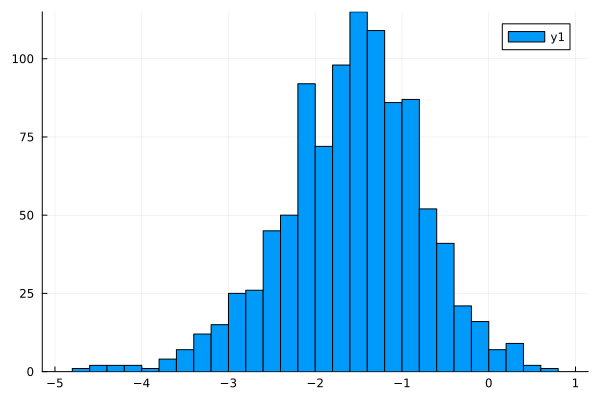

In [145]:
histogram(postDF[:, 5])

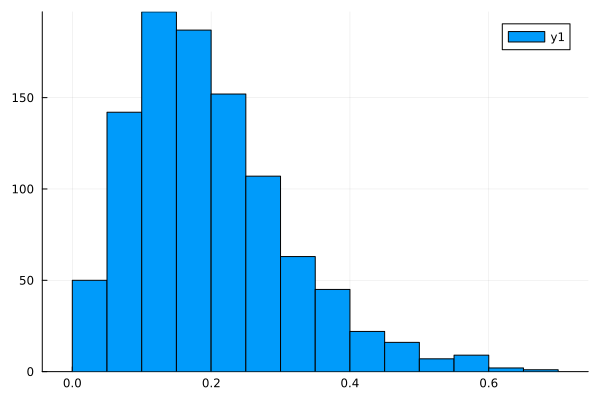

In [146]:
for i in 1:nrow(postDF)
    postDF[i,5] = logistic(postDF[i,5])
end

histogram(postDF[:,5])

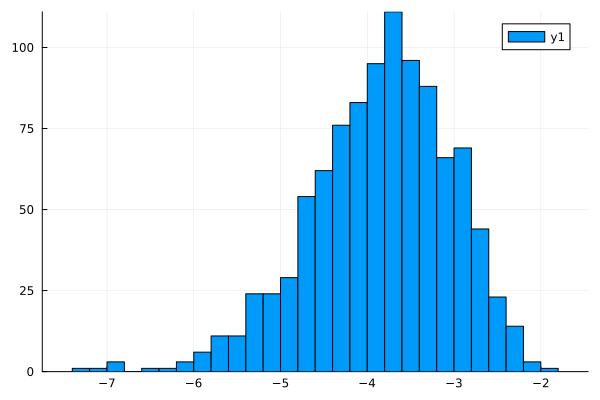

In [147]:
histogram(postDF[:, 6])

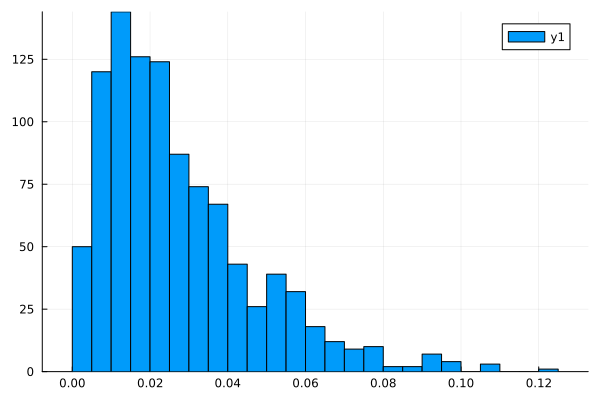

In [148]:
for i in 1:nrow(postDF)
    postDF[i,6] = logistic(postDF[i,6])
end

histogram(postDF[:,6])